The purpose of this notebook is to illustrate how to compute the adapted boostrap procedure described in Sulis et al. (2017).
In this example, we use synthetic time series of a colored noise generated as an autoregressive noise (see e.g. Value-at-Risk, 2nd Edition – by G. A. Holton, https://www.value-at-risk.net/autoregressive-processes).

We define the observed irregularly sampled time series by $X(t)$.
We assume we are able to generate $\{X_\ell(t)\}_{\ell=1,...,L}$ simulated time series of $X(t)$ under the null hypothesis ($\cal{H}_0$). 

We define the standardized periodogram of these observations as:
\begin{equation} 
         \widetilde{P}(\nu_k):= \frac{P(\nu_k)}{\overline{P}_L(\nu_k)}, 
\end{equation}

with $\nu_k$ the discrete frequencies, $P$ the periodogram of $X(t)$ and $\overline{P}_L$ the averaged periodogram defined as

\begin{equation} 
        \overline{P}_L(\nu_k | {\cal H}_0): = \frac{1}{L}~\sum_{\ell=1}^{L}~P_\ell(\nu_k)
\end{equation}

with $P_\ell(\nu_k)$ the periodogram corresponding to the series $X_\ell(t)$.
Our procedure will estimate the false alarm probability (FAP) of test 

\begin{equation}
 T_{M}({\bf{\widetilde{P}\;|\;\overline{P}}}_L):= \displaystyle{\max_k} ~\widetilde{P}(\nu_k) ~ \mathop{\gtrless}_{\mathcal{H}_0}^{\mathcal{H}_1} \gamma.
\end{equation}

applied to the standardized periodogram.



In [11]:
# Setup the packages we need
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

import sys
import numpy as np
import matplotlib.pyplot as plt

from astropy import stats
from astropy.stats import LombScargle
from statsmodels.distributions.empirical_distribution import ECDF

from numpy.linalg import inv


We create a synthetic time series of colored noise, that will serve as our "observations" $X(t)$. To create this colored noise, we used an autoregressive process. 

In [12]:
# Function which generates an AR noise process
def ARgenerator(pfunc,n,burnin=0):
  coefs,sigma2 = pfunc
  sigma = sigma2**0.5  
  if(burnin==0): burnin=100*len(coefs)       # Burn-in elements!
  w=np.random.normal(0,sigma,n+burnin)
  AR=np.array([])
  s=0.0
  for i in range(n+burnin):
      if(i<len(coefs)):
        AR=np.append(AR,w[i])
      else:
        s=0.0
        for j in range(len(coefs)):
            s=s+coefs[j]*AR[i-j-1]
        AR=np.append(AR,s+w[i])     
  return AR[burnin:]

# creation of synthetic observations
Nreg = 1000 # number of data point in a regular grid
dt   = 1    # data sampling [arbitrary unit]
coefs = [0.7, 0.05, 0, .3, 0, -.3] # autoreegressive coefficients (ex for an AR(6))     
sig  = 2.0              # standard deviation of the AR process
ytot  = ARgenerator([coefs,sig**2], Nreg) # synthetic observations (regularly sampled)
ttot =  np.linspace(0,Nreg*dt, Nreg) # time of the observations (regularly sampled)

# generate gaps within data
N = 100 # number of data point in the observed time series
import random
r = random.sample(range(0, Nreg), N) # generate random N unique numbers in interval [0,Nreg]
ind_irr = np.sort(r) # order these random number
t    = ttot[ind_irr]    # create the irregularly sampled time array
data = ytot[ind_irr]    # create the irregularly sampled observations array

 We plot our irregularly sampled time series

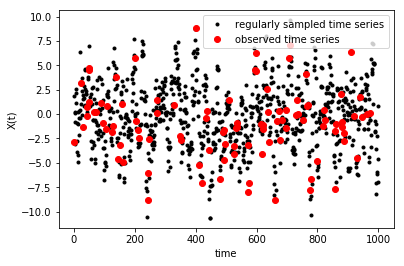

In [13]:
plt.figure()
plt.plot(ttot,ytot,'k.', label='regularly sampled time series')
plt.plot(t,data,'ro', label='observed time series')
plt.xlabel('time')
plt.ylabel('X(t)')
plt.legend()

Now, we generate a long time series to mimic the simulated noise time series under $\cal{H}_0$. This time series has to be cut in $L$ segments to represent $X_\ell(t)$. 

In [14]:
L =  2 # number of simulated noise time series we assume to have
ysynth = ARgenerator([coefs,sig**2], L*Nreg)  # synthetic noise time series

We create a function that will estimate the parameters of an AR noise given a time series

In [15]:
# Function: criterion to estimate the best AR order 
def ARcriterion(criter, Varp, N, p, X=[]):
    
    if criter =='FPE':
        return Varp * ( (N+p+1)/(N-p-1) )

    if criter =='CAT':
        som=0
        for j in range(1,p):
            Varp_j, _ = Prediction_error_power_estimate(X, p)  
            som+= (N-j)/(N*Varp_j)
        return 1.0/N * som - (N-p)/(N*Varp)

    if criter =='AIC':
        return np.log(Varp) + 2*(p+1)/N

    if criter =='RIS':
        return Varp * ( 1 + (p+1)/N*np.log(N) )

    
# Function: estimate the predicted error power estimate 
def Prediction_error_power_estimate(X, p):
        
    N = len(X)
    X = X - np.mean(X)
    
    # Autocovariance matrix (see p.244 of Akaike, 1969)    
    Cxx = [0 for i in range(p+1)]             
    for il in range(0,p+1):
        somme = 0.0
        for i in range(1,N-il):
            somme += X[i+il] * X[i]
        Cxx[il]  = [1.0/N * somme]           
    Cxx_matrix =    np.mat(Cxx)

    # Define the index of this matrix (note: Cxx(-i)=Cxx(i)) 
    ind_Matrix = [[0 for i in range(p)] for j in range(p)]
    for ligne in range(0,p):                  # line (2 : p), colonne(:)
        i=ligne;       
        for col in range(0,p):            # ligne (i), colonne(col)
            ind_Matrix[ligne][col] = np.abs(i) 
      	    i -= 1 
            
	# Fill matrix M_Cxx
    M_Cxx = np.zeros((p,p))
    for j in range(p): M_Cxx[j] = np.mat([ Cxx[ind_Matrix[i][j]][0] for i in range(p)])
    M_Cxx = np.mat(M_Cxx)
    
    # Evaluate coeficients alpha_i by inverting matrix M_Cxx
    alpha =  inv(M_Cxx)*Cxx[1:]
    
    model = np.zeros(N)
    model[:p] = X[:p]
    
    m = np.arange(0,p)  # i1 = 1:p
    for nn in range(p,N):
        i2 = np.sort(nn - m)
        model[nn] = np.sum(np.array(alpha.T) * X[i2])

    Var_p = 1.0/N/4 * np.sum((X[p:N] + model[p:N])**2)
   
    return Var_p, -alpha

# Function: estimate the best parameters of an AR process given a time serie X.
def AR_estimation(X, argfunc):

    pmax,criter = argfunc # argument of the function (max AR order and estimation criterion)
    
    N = len(X);
    X = X - np.mean(X)
    
    # find the best order of the AR process
    crit = np.zeros(pmax)
    for p in range(1,pmax+1):        
        Varp, alp = Prediction_error_power_estimate(X, p)  
        if criter != 'CAT':          
            crit[p-1] = ARcriterion(criter, Varp, N, p)
        else:
            crit[p-1] = ARcriterion(criter, Varp, N, p,X)
                
    order = np.where(crit == min(crit))[0]
    order = np.min(order)+1
    # Evaluate coefficient alpha_PL with the best order 
    Varp, alp = Prediction_error_power_estimate(X, order)
    alpha = -np.array(alp.T)[0]
    return [alpha,Varp]


Set up the parameters that will be used in the function "adapted bootstrap".

In [16]:
pmax = 10 # maximum AR order to search for
criterion = 'FPE' # criterion to estimate the best AR order
func_parametric =  AR_estimation # function to estimate the AR model
run_parametric  =  ARgenerator # function to generate synthetic AR time series

# Set up the type of periodogram to compute
tP='LS' # 'LS' for Lomb-Scargle periodogram 


Check the choice we have made for the parametric function (here an AR model, i.e. the true model we have used to generate this example)

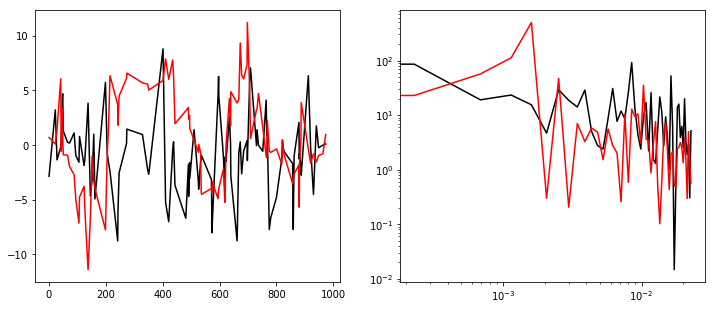

In [17]:
def fit_check(t,y,run_parametric, pfunc, typePeriodo = 'FT'):
        
    yhat = run_parametric(pfunc,len(y))
    if typePeriodo == 'LS':
        ls  = LombScargle(t, y)
        f, p = ls.autopower()
        ls = LombScargle(t, yhat)
        _, phat = ls.autopower()
    if typePeriodo == 'FT':
        dt = t[1]-t[0]
        f  = np.linspace(-1./2/dt, 1./2/dt, len(t)) 
        p = 1.0/len(yhat) * np.abs(np.fft.fftshift(np.fft.fft(y)))**2 
        phat = 1.0/len(yhat) * np.abs(np.fft.fftshift(np.fft.fft(yhat)))**2 
    
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.plot(t,y,'k')
    plt.plot(t,yhat,'r')
    plt.subplot(122)
    plt.loglog(f, p,'k')
    plt.loglog(f,phat,'r')

# Check this choice
argfunc = [pmax,criterion] # argument of the function (order, criterion to estimate the best order)
pfunc = func_parametric(ysynth, argfunc)
fit_check(t,data,run_parametric, pfunc, typePeriodo = 'FT')


Define and run the adapted bootstrap procedure.

Warning.1 : depending to the (double) number of Monte Carlo simulations you want to generate (i.e. parameters NMC_loop1, NMC_loop2 in the boxes above), the code may take some time. If the code is run in the Jupyter notebook, we advice to set NMC_loop1 $<10$ and NMC_loop2 $<1000$. If the code is run outside the notebook, good values are NMC_loop1 $\in [10-100]$  and NMC_loop2 $\in [1000,10000]$.

Warning.2 : wait until the message 'Computing is done' appears to continue running the other cells of this notebook.

In [20]:
# Compute Lomb-Scargle periodogram
# documentation: https://docs.astropy.org/en/stable/timeseries/lombscargle.html#id32
def func_periodo(tirr, yhat, typePeriodo = 'LS'):
    if typePeriodo == 'LS':
        ls = LombScargle(tirr, yhat)
        _, psd = ls.autopower()        
    return psd

# Compute the averaged periodogram
def func_averag_periodo(tirr, ind_irr, N, L, Npow, run_parametric, p, typePeriodo = 'LS'):
    PL = np.zeros((L,Npow))
    for il in range(L):
        yhat_il = run_parametric(p, N)
        yhat_il = yhat_il[ind_irr]
        PL[il] = func_periodo(tirr, yhat_il, typePeriodo=typePeriodo)        
    return np.mean(PL,0)

# Function adapted bootstrap
# Return NMC_loop1 PFA estimates (length: NMC_loop2)
def adapted_bootstrap(tirr, ysimus_reg, ind_irr, NMC_loop1, NMC_loop2, L, func_parametric, argfunc, run_parametric,typePeriodo='LS'):
    
    # Number of data points 
    Ntot = len(ysimus_reg)
    N  = np.int(Ntot/L)
    
    # initialisation arrays thresholds and pfa
    gam = np.zeros((NMC_loop1,NMC_loop2))
    pfa = np.zeros((NMC_loop1,NMC_loop2))
    
    # 1st parametric estimation of the noise time series
    # note: estimation on whole synthetic series with Ntot >= N
    pfunc_est1 = func_parametric(ysimus_reg, argfunc)
        
    # Loop 1: determine the distribution dpfa
    for iloop1 in range(NMC_loop1):

        # Re-generation and 2nd parametric estimation of the noise time series
        ysimus_hat   = run_parametric(pfunc_est1, Ntot)
        pfunc_est2 = func_parametric(ysimus_hat, argfunc)

        # Loop 2: determine the pfa
        TM = np.zeros(NMC_loop2)
        for iloop2 in range(NMC_loop2):

            # generate a synthetic noise time series
            yhat     =  run_parametric(pfunc_est2, N)
            yhat_irr =  yhat[ind_irr]
            
            # compute periodogram
            num = func_periodo(tirr, yhat_irr, typePeriodo=typePeriodo)            
            den = func_averag_periodo(tirr, ind_irr, N, L, len(num), run_parametric,  pfunc_est2, typePeriodo=typePeriodo)
            pstand = num / den
            # compute statistical test on periodogram
            TM[iloop2] = np.max(pstand)
        
        # Evaluate PFA estimate
        ecdf = ECDF(TM) 
        gam[iloop1]   = ecdf.x[1:]
        pfa[iloop1]   = 1.0-ecdf.y[1:]
    
    return gam, pfa

# Set up the number of Monte Carlo simulations to use in the boostrap function
# NMC_loop1 represents the number of pfa estimates we want to generate (to access to the distribution of these estimates). More this value is large, better we will be able to borned the true pfa.
# NMC_loop2 represents the number of test statistics to generate to access to a SINGLE pfa estimate. More this value is large, more we will access to small pfa.
NMC_loop1, NMC_loop2 = 2,100 # for Jupiter notebook 
#NMC_loop1, NMC_loop2 = 100, 1000 # if large computation ok (computer)

# run the adapted boostrap procedure (do not use the "data" but only the synthetic noise time series "ysynth")
gam, pfa = adapted_bootstrap(t, ysynth , ind_irr, NMC_loop1, NMC_loop2, L, func_parametric, argfunc, run_parametric, typePeriodo=tP)

print '>> Computing is done'

>> Computing is done


To compare, compute the true FAP of this AR noise process

In [21]:
# estimate the true PFA of an AR noise process irregularly sampled
def true_pfa_AR(NMC, ttot, ind_irr,coefs, sig, Nreg, dt, L, run_parametric, typePeriodo = 'LS' ):
    pfunc_true = [coefs,sig**2]
    
    TM = np.zeros(NMC)
    for j in range(NMC):
    
        # generate gaps within data
        ytot  = ARgenerator([coefs,sig**2], Nreg)
        tirr = ttot[ind_irr]
        yirr = ytot[ind_irr]
    
        # compute periodogram
        num = func_periodo(tirr, yirr, typePeriodo=typePeriodo)            
        den = func_averag_periodo(tirr, ind_irr, Nreg, L, len(num), run_parametric, pfunc_true, typePeriodo=typePeriodo)
        pstand = num / den
        
        # compute statistical test on periodogram
        TM[j] = np.max(pstand)

    # Evaluate PFA estimate
    ecdf = ECDF(TM) 
    gam_true = ecdf.x[1:]
    pfa_true = 1.0-ecdf.y[1:]

    return gam_true, pfa_true

# compute the true pfa
gam_true, pfa_true = true_pfa_AR(NMC_loop2, ttot, ind_irr,coefs, sig, Nreg, dt, L, run_parametric, typePeriodo=tP )

print '>> Computing is done'

>> Computing is done


Plot the results

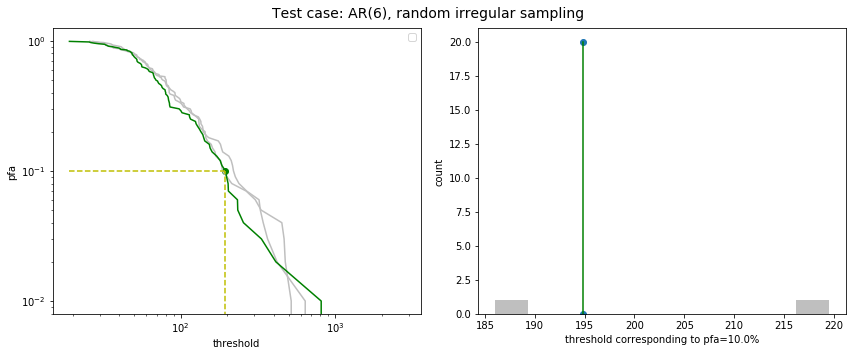

In [22]:
# To plot the distrution of the pfa estimates around a given pfa (subplot number 2)
pref = 10./100 # ex. given pfa = 10%

# look for the thresholds at this pfa from the estimates
gpfa_1pc = np.zeros(NMC_loop1)
for i in range(NMC_loop1):
    tmp = np.abs(pfa[i] - pref)
    wpfa = np.where(tmp ==np.min(tmp))
    gpfa_1pc[i] = gam[i][wpfa]
# look for the threshold at this pfa from the true pfa
tmp = np.abs(pfa_true - pref)
wpfa = np.where(tmp ==np.min(tmp))
gpfa_true_1pc = gam_true[wpfa]

# figure
figg=plt.figure(figsize=(12,5))
figg.suptitle("Test case: AR(6), random irregular sampling", fontsize=14)

# first plot the fap as a function of the threshold
plt.subplot(121)
for iloop1 in range(NMC_loop1):plt.loglog(gam[iloop1], pfa[iloop1],'0.75')
plt.loglog(gam_true, pfa_true,'g')
plt.plot([np.min(gam_true),gpfa_true_1pc],[pref,pref],'y--')
plt.plot([gpfa_true_1pc,gpfa_true_1pc],[np.min(pfa_true),pref],'y--')
plt.scatter(gpfa_true_1pc,pref,marker='o',color='g')
plt.xlabel('threshold')
plt.ylabel('pfa')
plt.legend()

plt.subplot(122)
plt.hist(gpfa_1pc,color='0.75')
plt.stem([gpfa_true_1pc,gpfa_true_1pc],[0,20],'g')
plt.xlabel('threshold corresponding to pfa='+str(pref*100)+'%')
plt.ylabel('count')

figg.tight_layout()
figg.subplots_adjust(top=0.92)


The right panel shows the PFA as a function of the detection threshold. True value is shown in green, PFA estimates resulting from the adapted bootstrap procedure are shown in grey. The dashed yellow lines illustrates the PFA level of $10\%$ and the corresponding true threshold (between [220-230]).
The left panel shows the dipersion of the PFA estimates (grey histogram) that are centered around the true PFA value (green).

If parameters NMC_loop1, NMC_loop2 are sufficiently large (e.g. NMC_loop1 $=100$ and NMC_loop2 $=10000$), we obtain the figure below. 


<img src="Test_AR2.png">